In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
import seaborn as sn
import pandas as pd

In [2]:
# Define GPU support
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


1. Load Data

In [3]:
data = np.load('bloodmnist.npz')
print(data)

NpzFile 'bloodmnist.npz' with keys: train_images, train_labels, val_images, val_labels, test_images...


In [4]:
import medmnist
from medmnist import INFO, Evaluator

In [32]:
def test(DNN_Model, test_loader, classes, batch_size, n_classes):
    equality = 0
    test_accuracy = 0
    sample_size = 16
    DNN_Model.eval()
    cf_labels = torch.empty(test_loader.dataset.tensors[1].size(0), dtype=torch.int64).to(device)
    cf_prediction = torch.empty(test_loader.dataset.tensors[1].size(0), dtype=torch.int64).to(device)

    with torch.no_grad():
        for i, (images,labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.view(-1).type(torch.int64).to(device)
            cf_labels[i*batch_size:i*batch_size+batch_size] = labels
        
            test_output = DNN_Model(images)
            cf_prediction[i*batch_size:i*batch_size+batch_size] = test_output.max(dim=1)[1]
            
            equality = (test_output.max(dim=1)[1] == labels)
            test_accuracy += equality.type(torch.FloatTensor).mean()
        
    test_accuracy = test_accuracy/len(test_loader)

    print(f'Test Accuracy: {test_accuracy:.4f}')

#  compute Precision and Recall Scores for each class
    cf_labels2 = []
    for i in range(len(cf_labels)):
        cf_labels2.append(classes[str(cf_labels[i].to('cpu').item())][:21])

    cf_prediction2 = []
    for i in range(len(cf_prediction)):
        cf_prediction2.append(classes[str(cf_prediction[i].to('cpu').item())][:21])

    print(classification_report(cf_labels2, cf_prediction2))

    # bulding confusion matrix
    cf_classes = []
    for i in range(n_classes):
        cf_classes.append(classes[str(i)][:21])

    cf_matrix = confusion_matrix(cf_labels.to('cpu').numpy(), cf_prediction.to('cpu').numpy())
    df_cm = pd.DataFrame(cf_matrix, index = cf_classes, columns = cf_classes)
    plt.figure(figsize = (14,7))
    sn.heatmap(df_cm, annot=True, fmt=".0f")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()

    # showing examples
    plt.figure()
    for i in range(sample_size):
        fig = plt.subplot(4,4,i+1)
        plt.imshow(np.transpose((images[i]*0.5+0.5).to('cpu').numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.title(f'Prediction: {classes[str(test_output.max(dim=1)[1][i].item())][:21]}\n sample: {classes[str(labels[i].item())][:21]}')
        
    plt.subplots_adjust(right=2, top=2.7)

In [6]:
# BloodMNIST dataset information
data_flag = 'bloodmnist'

info = INFO[data_flag]
n_channels = info['n_channels']
classes = info['label']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
cml_labels = {}
for i in range(len(classes)):
    cml_labels[classes[str(i)]] = i
info


{'python_class': 'BloodMNIST',
 'description': 'The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/bloodmnist.npz?download=1',
 'MD5': '7053d0359d879ad8a5505303e11de1dc',
 'url_64': 'https://zenodo.org/records/10519652/files/bloodmnist_64.npz?download=1',
 'MD5_64': '2b94928a2ae4916078ca51e05b6b800b',
 'url_128': 'https://zenodo.org/records/10519652/files/bloodmnist_128.npz?download=1',
 'MD5_128': 'adace1e0ed228fccda1f39692059dd4c',
 'url_224': 'https://zenodo.org/records/10519652/files/bloodmnist

2. Preprocess Data

In [26]:
# def preprocess_images(images):
#     images = images / 255.0  # Normalize to range [0, 1]
#     images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
#     return images

# def preprocess_labels(labels):
#     labels = labels.flatten()
#     labels = LabelEncoder().fit_transform(labels)  # Encode labels as integers
#     return torch.tensor(labels, dtype=torch.long)

# train_images = preprocess_images(data['train_images'])
# train_labels = preprocess_labels(data['train_labels'])
# val_images = preprocess_images(data['val_images'])
# val_labels = preprocess_labels(data['val_labels'])
# test_images = preprocess_images(data['test_images'])
# test_labels = preprocess_labels(data['test_labels'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# load the data
train_dataset = DataClass(split='train', transform=transform, download=True)
val_dataset = DataClass(split='val', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)
print(f'Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Test samples: {len(test_dataset)}')

# count the number of samples in each class
count = []
for i in range(n_classes):
    count.append((train_dataset.labels == i).sum())
    print(f'{classes[str(i)]}: {count[i]}')

100%|██████████| 35.5M/35.5M [00:04<00:00, 8.48MB/s]


Using downloaded and verified file: /home/shweta/.medmnist/bloodmnist.npz
Using downloaded and verified file: /home/shweta/.medmnist/bloodmnist.npz
Train samples: 11959, Validation samples: 1712, Test samples: 3421
basophil: 852
eosinophil: 2181
erythroblast: 1085
immature granulocytes(myelocytes, metamyelocytes and promyelocytes): 2026
lymphocyte: 849
monocyte: 993
neutrophil: 2330
platelet: 1643


In [8]:
# Check no records are missing
print('Training: no. images: {}, no. labels: {}'.format(len(train_images), len(train_labels)))
print('Validation: no. images: {}, no. labels: {}'.format(len(val_images), len(val_labels)))
print('Testing: no. images: {}, no. labels: {}'.format(len(test_images), len(test_labels)))

Training: no. images: 11959, no. labels: 11959
Validation: no. images: 1712, no. labels: 1712
Testing: no. images: 3421, no. labels: 3421


3. Create DataLoader Objects

In [9]:
batch_size = 1024
sample_size = 16
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_images, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(test_images, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

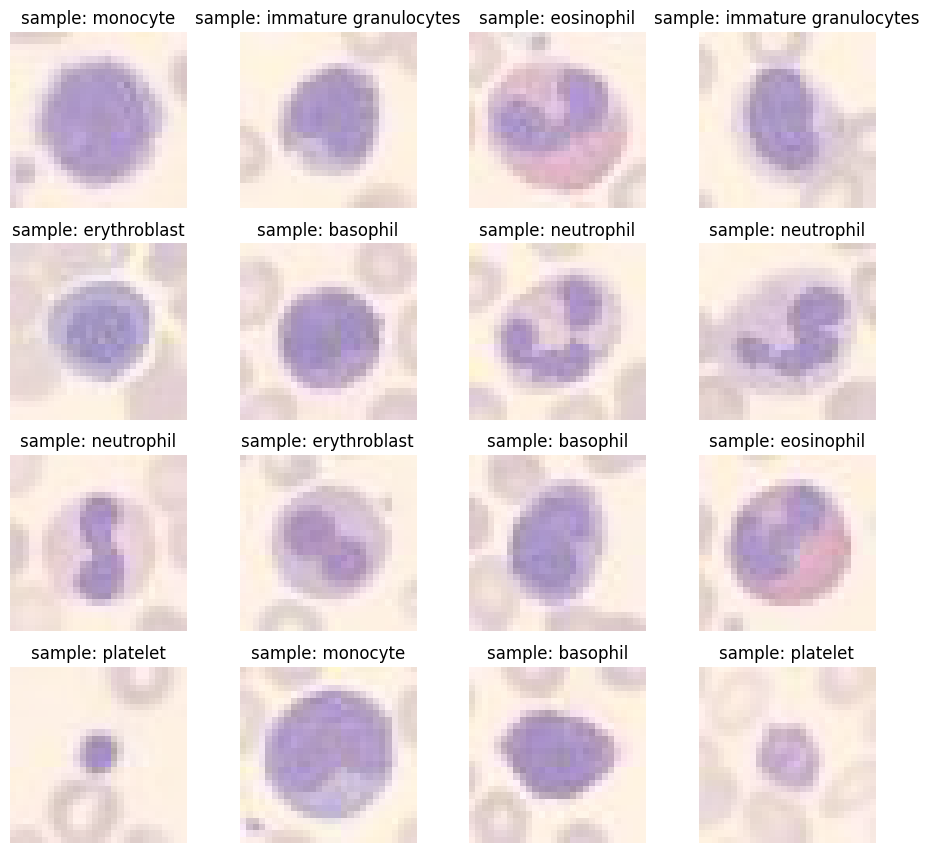

In [20]:
# show some random training images
images, labels = next(iter(train_loader))
plt.figure()
for i in range(sample_size):
    fig = plt.subplot(4,4,i+1)
    plt.imshow(np.transpose((images[i]*0.5+0.5).to('cpu').numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f'sample: {classes[str(labels[i].item())][:21]}')
    
plt.subplots_adjust(right=1.5, top=1.8)

4. Build a DNN Model

In [11]:
class DNN_Model(nn.Module):
    def __init__(self):
        super(DNN_Model, self).__init__()
        self.FC1 = nn.Linear(3*28*28,1024)
        self.RelU1 = nn.ReLU()
        self.FC2 = nn.Linear(1024, 128)
        self.RelU2 = nn.ReLU()
        self.FC3 = nn.Linear(128, 8)
        self.Dropout = nn.Dropout(0.25)
        self.Smax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 3*28*28) # flatten all dimensions except the batch dimension
        x = self.FC1(x)
        x = self.RelU1(x)
        x = self.FC2(x)
        x = self.RelU2(x)
        x = self.FC3(x)
        x = self.Dropout(x)
        x = self.Smax(x)
        return x

dnn_model = DNN_Model().to(device)
summary(dnn_model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       2,409,472
              ReLU-2                 [-1, 1024]               0
            Linear-3                  [-1, 128]         131,200
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 8]           1,032
           Dropout-6                    [-1, 8]               0
        LogSoftmax-7                    [-1, 8]               0
Total params: 2,541,704
Trainable params: 2,541,704
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 9.70
Estimated Total Size (MB): 9.72
----------------------------------------------------------------


5. Train the Model

In [12]:
# validation function
def validate(model, loss_func, val_loader):
    val_loss = 0
    equality = 0
    val_accuracy = 0
    for i, (images,labels) in enumerate(val_loader):
        images = images.to(device)
        labels = labels.view(-1).type(torch.int64).to(device)

        val_output = model(images)
        val_loss += loss_func(val_output, labels).item()
         
        equality = (val_output.max(dim=1)[1] == labels)
        val_accuracy += equality.type(torch.FloatTensor).mean()
    
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)

    return val_loss, val_accuracy


learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnn_model.parameters(), lr=learning_rate)
epochs = 50
n_total_steps = len(train_loader)
val_every = int(n_total_steps/5)
train_loss= []
train_acc = 0
train_acc_list = []
val_loss_list = []
val_acc_list = []
iterations = 0
dnn_model.train()

# starting the training loop
for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.view(-1).type(torch.int64).to(device)

        # Forward pass
        output = dnn_model(images)
        loss = loss_func(output, labels)
        
        # calculate training accuracy
        with torch.no_grad():
            equality = (output.max(dim=1)[1] == labels)
            train_acc += equality.type(torch.FloatTensor).mean()
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % val_every == 0:
            dnn_model.eval()

            # calculate validation loss and accuracy
            with torch.no_grad():
                 val_loss, val_acc = validate(dnn_model, loss_func, val_loader)

            train_acc_list.append(train_acc/iterations)
            train_loss.append(loss.item())
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Training Loss: {loss.item():.4f}, Training Accuracy: {train_acc/iterations:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr = {learning_rate}')
            dnn_model.train()

Epoch [1/50], Step [1/12], Training Loss: 2.0828, Training Accuracy: 0.1533, Validation Loss: 2.1596, Validation Accuracy: 0.1676, lr = 0.001
Epoch [1/50], Step [3/12], Training Loss: 2.1157, Training Accuracy: 0.1849, Validation Loss: 2.0531, Validation Accuracy: 0.1831, lr = 0.001
Epoch [1/50], Step [5/12], Training Loss: 2.0129, Training Accuracy: 0.1842, Validation Loss: 1.9711, Validation Accuracy: 0.1832, lr = 0.001
Epoch [1/50], Step [7/12], Training Loss: 1.9964, Training Accuracy: 0.1854, Validation Loss: 1.9555, Validation Accuracy: 0.2778, lr = 0.001
Epoch [1/50], Step [9/12], Training Loss: 1.9611, Training Accuracy: 0.1977, Validation Loss: 1.9279, Validation Accuracy: 0.1929, lr = 0.001
Epoch [1/50], Step [11/12], Training Loss: 1.9171, Training Accuracy: 0.2100, Validation Loss: 1.8976, Validation Accuracy: 0.3169, lr = 0.001
Epoch [2/50], Step [1/12], Training Loss: 1.8583, Training Accuracy: 0.2229, Validation Loss: 1.8413, Validation Accuracy: 0.3852, lr = 0.001
Epoch

6. Save the DNN Model

In [13]:
path = f'models/DNN_model.pth'
torch.save(dnn_model.state_dict(), path)

Training Accuracy: 0.6124
Validation Accuracy: 0.8133
Training Loss: 0.7202
Validation Loss: 0.5407


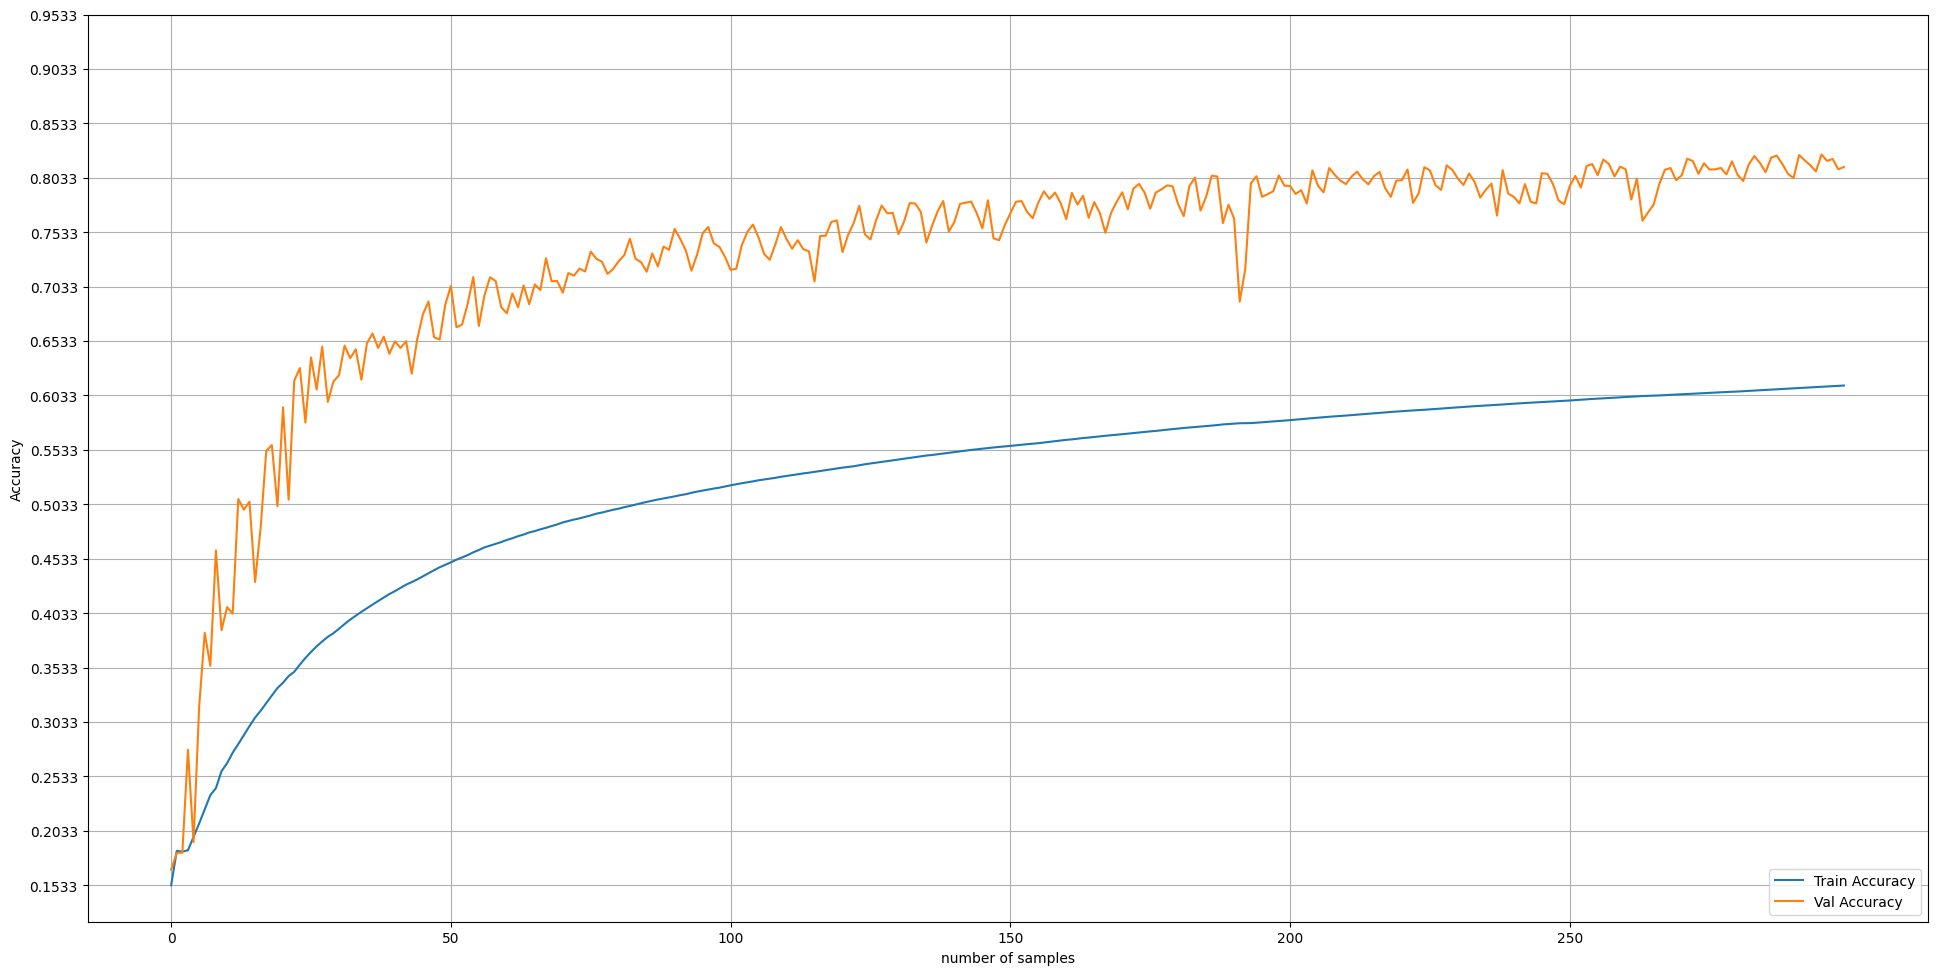

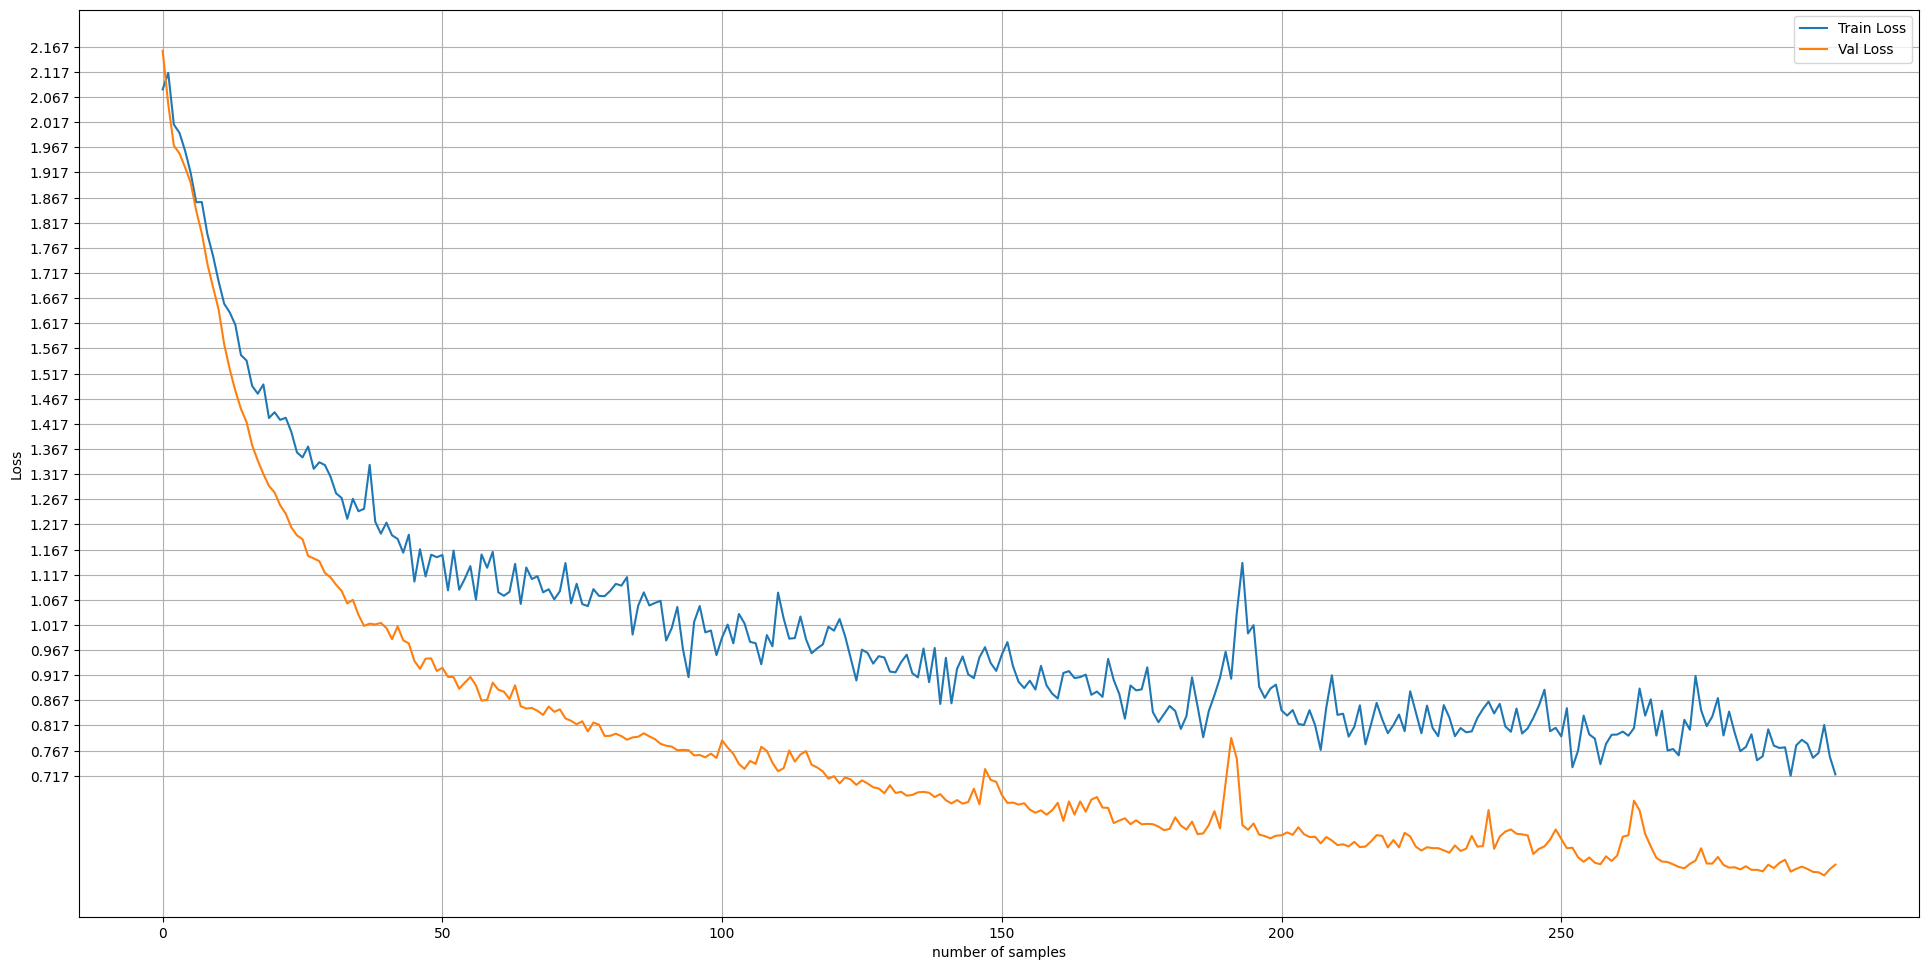

In [14]:
# display DNN Model loss and accuracy graphs
# accuracy graph function
def acc_graph(train_acc, val_acc):
    print(f'Training Accuracy: {train_acc[-1].item():.4f}')
    print(f'Validation Accuracy: {val_acc[-1].item():.4f}')
    _, ax = plt.subplots()
    plt.plot(range(len(train_acc)),train_acc,val_acc)
    plt.xticks(np.arange(min(range(len(train_acc))), max(range(len(train_acc)))+1, 50))
    plt.yticks(np.arange(min(train_acc), 1, 0.05))
    plt.grid()
    plt.legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')
    plt.xlabel('number of samples')
    plt.ylabel('Accuracy')
    plt.subplots_adjust(right=3, top=2)

def loss_graph(train_loss, val_loss):
    print(f'Training Loss: {train_loss[-1]:.4f}')
    print(f'Validation Loss: {val_loss[-1]:.4f}')
    plt.figure()
    plt.plot(range(len(train_loss)),train_loss,val_loss)
    plt.xticks(np.arange(min(range(len(train_loss))), max(range(len(train_loss)))+1, 50))
    plt.yticks(np.arange(min(train_loss), max(train_loss)+0.1, 0.05))
    plt.grid()
    plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
    plt.xlabel('number of samples')
    plt.ylabel('Loss')
    plt.subplots_adjust(right=3, top=2)


acc_graph(train_acc_list, val_acc_list)
loss_graph(train_loss, val_loss_list)

DNN Model
Test Accuracy: 0.8069
                       precision    recall  f1-score   support

             basophil       0.82      0.51      0.63       244
           eosinophil       0.91      0.95      0.93       624
         erythroblast       0.83      0.79      0.81       311
immature granulocytes       0.54      0.82      0.65       579
           lymphocyte       0.86      0.69      0.76       243
             monocyte       0.73      0.33      0.46       284
           neutrophil       0.90      0.87      0.89       666
             platelet       0.97      0.99      0.98       470

             accuracy                           0.80      3421
            macro avg       0.82      0.74      0.76      3421
         weighted avg       0.82      0.80      0.80      3421



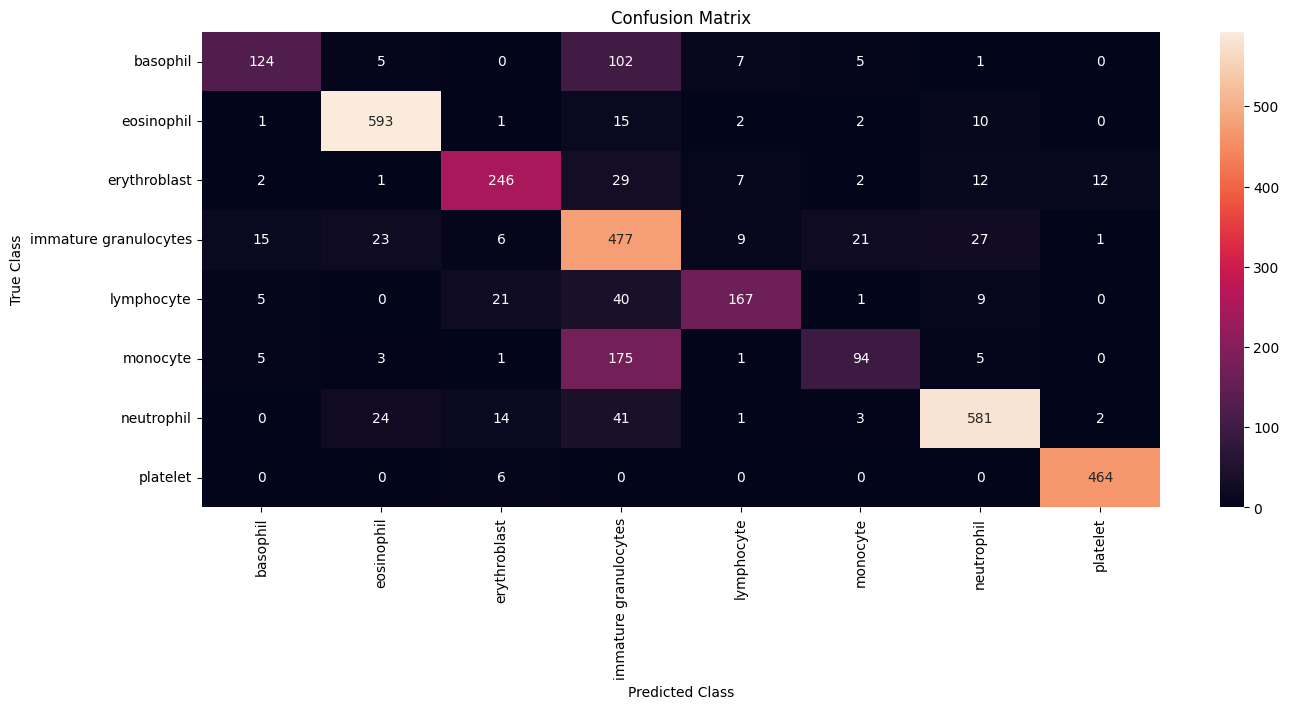

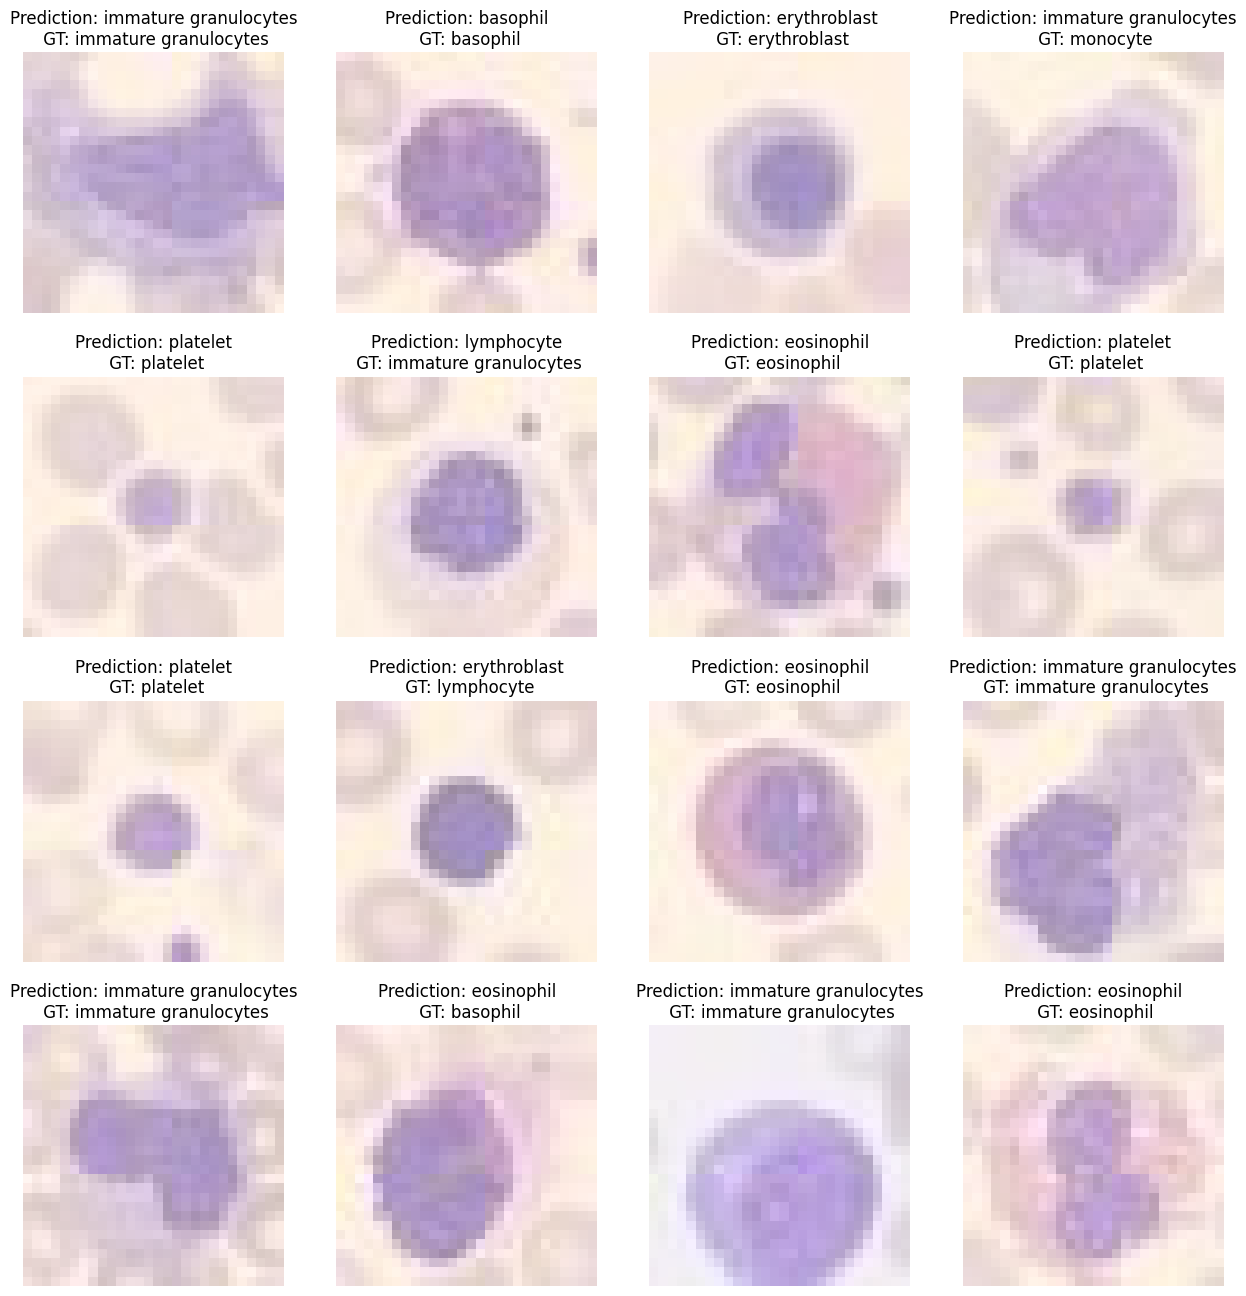

In [21]:
# test the DNN model
# test function
    
print("DNN Model")
test(dnn_model, test_loader, classes, batch_size, n_classes)

Build a CNN Model

In [23]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.Conv1 = nn.Conv2d(3,32,3)
        self.RelU1 = nn.ReLU()

        self.Conv12 = nn.Conv2d(32,64,3)
        self.RelU12 = nn.ReLU()
        self.Maxpool1 = nn.MaxPool2d(2)

        self.Conv2 = nn.Conv2d(64,128,3)
        self.RelU2 = nn.ReLU()

        self.Conv22 = nn.Conv2d(128,256,3)
        self.RelU22 = nn.ReLU()
        self.Maxpool2 = nn.MaxPool2d(2)

        self.Fc1 = nn.Linear(256*4*4,1024)
        self.RelU3 = nn.ReLU()

        self.Fc2 = nn.Linear(1024,512)
        self.RelU4 = nn.ReLU()

        self.Fc3 = nn.Linear(512,8)
        self.Dropout2  = nn.Dropout(0.3)
        self.Smax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.Conv1(x)
        x = self.RelU1(x)
        x = self.Conv12(x)
        x = self.RelU12(x)
        x = self.Maxpool1(x)
        x = self.Conv2(x)
        x = self.RelU2(x)
        x = self.Conv22(x)
        x = self.RelU22(x)
        x = self.Maxpool2(x)
        x = x.view(-1, 256*4*4) # flatten all dimensions except the batch dimension
        x = self.Fc1(x)
        x = self.RelU3(x)
        x = self.Fc2(x)
        x = self.RelU4(x)
        x = self.Fc3(x)
        x = self.Dropout2(x)
        x = self.Smax(x)
        return x

cnn_model = CNN_Model().to(device)
summary(cnn_model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             896
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
         MaxPool2d-5           [-1, 64, 12, 12]               0
            Conv2d-6          [-1, 128, 10, 10]          73,856
              ReLU-7          [-1, 128, 10, 10]               0
            Conv2d-8            [-1, 256, 8, 8]         295,168
              ReLU-9            [-1, 256, 8, 8]               0
        MaxPool2d-10            [-1, 256, 4, 4]               0
           Linear-11                 [-1, 1024]       4,195,328
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
             ReLU-14                  [

Train the CNN Model

In [30]:
learning_rate = 0.0001
loss_func = nn.NLLLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
epochs = 50
n_total_steps = len(train_loader)
# val_every = int(n_total_steps/5)
train_loss= []
train_acc = 0
train_acc_list = []
val_loss_list = []
val_acc_list = []
iterations = 0
cnn_model.train()

# starting the training loop
for epoch in range(epochs):
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.view(-1).type(torch.int64).to(device)

        # Forward pass
        output = cnn_model(images)
        loss = loss_func(output, labels)
        
        # calculate training accuracy
        with torch.no_grad():
            equality = (output.max(dim=1)[1] == labels)
            train_acc += equality.type(torch.FloatTensor).mean()
            iterations += 1

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % val_every == 0:
            cnn_model.eval()

            # calculate validation loss and accuracy
            with torch.no_grad():
                 val_loss, val_acc = validate(cnn_model, loss_func, val_loader)

            train_acc_list.append(train_acc/iterations)
            train_loss.append(loss.item())
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            print (f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Training Accuracy: {train_acc/iterations:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}, lr = {learning_rate}')
            cnn_model.train()




Epoch [1/50], Training Loss: 0.9059, Training Accuracy: 0.6338, Validation Loss: 0.6630, Validation Accuracy: 0.7556, lr = 0.0001
Epoch [1/50], Training Loss: 0.9790, Training Accuracy: 0.6152, Validation Loss: 0.6091, Validation Accuracy: 0.7814, lr = 0.0001
Epoch [1/50], Training Loss: 0.8913, Training Accuracy: 0.6170, Validation Loss: 0.6039, Validation Accuracy: 0.7802, lr = 0.0001
Epoch [1/50], Training Loss: 0.9117, Training Accuracy: 0.6177, Validation Loss: 0.5938, Validation Accuracy: 0.7991, lr = 0.0001
Epoch [1/50], Training Loss: 0.8633, Training Accuracy: 0.6241, Validation Loss: 0.5728, Validation Accuracy: 0.7933, lr = 0.0001
Epoch [1/50], Training Loss: 0.8352, Training Accuracy: 0.6253, Validation Loss: 0.5877, Validation Accuracy: 0.7870, lr = 0.0001
Epoch [2/50], Training Loss: 0.9279, Training Accuracy: 0.6240, Validation Loss: 0.5684, Validation Accuracy: 0.7984, lr = 0.0001
Epoch [2/50], Training Loss: 0.7984, Training Accuracy: 0.6300, Validation Loss: 0.5618, V

Test the Model

CNN Model
Test Accuracy: 0.8625
                       precision    recall  f1-score   support

             basophil       0.69      0.63      0.66       244
           eosinophil       0.96      0.97      0.97       624
         erythroblast       0.95      0.84      0.89       311
immature granulocytes       0.69      0.78      0.73       579
           lymphocyte       0.81      0.86      0.84       243
             monocyte       0.68      0.59      0.63       284
           neutrophil       0.95      0.95      0.95       666
             platelet       0.98      0.99      0.98       470

             accuracy                           0.86      3421
            macro avg       0.84      0.83      0.83      3421
         weighted avg       0.86      0.86      0.86      3421



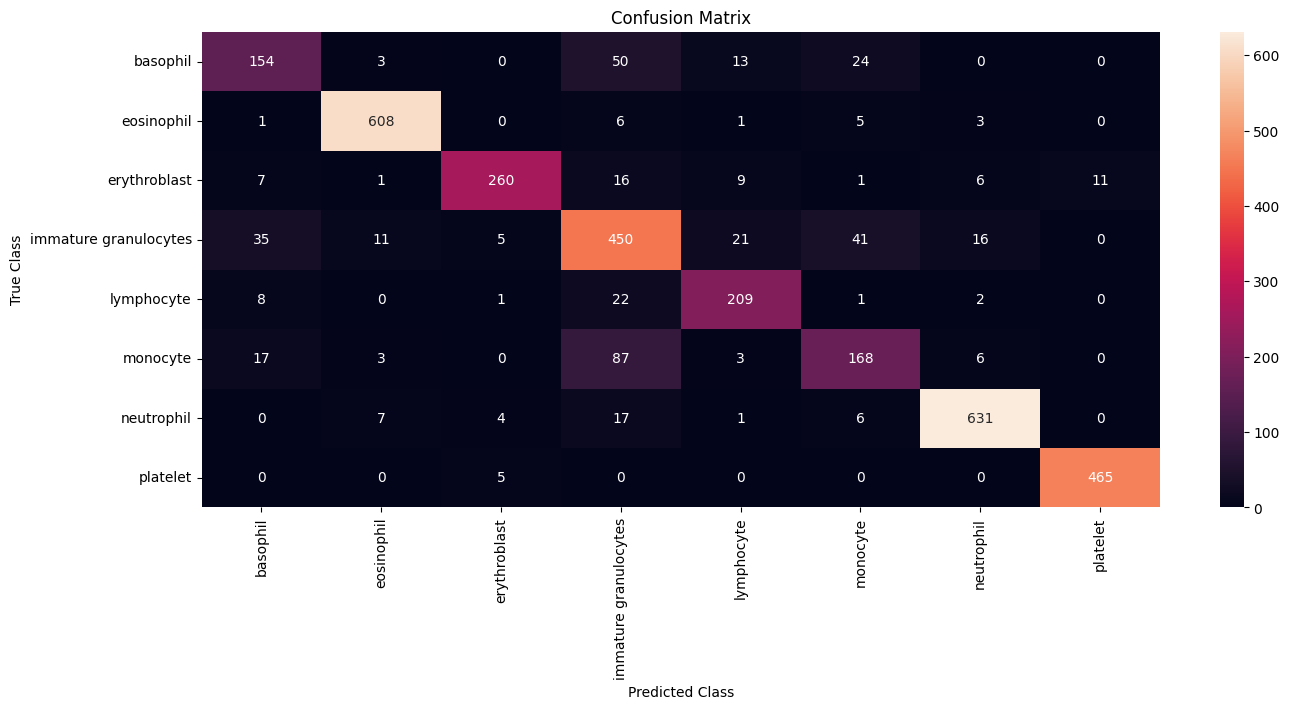

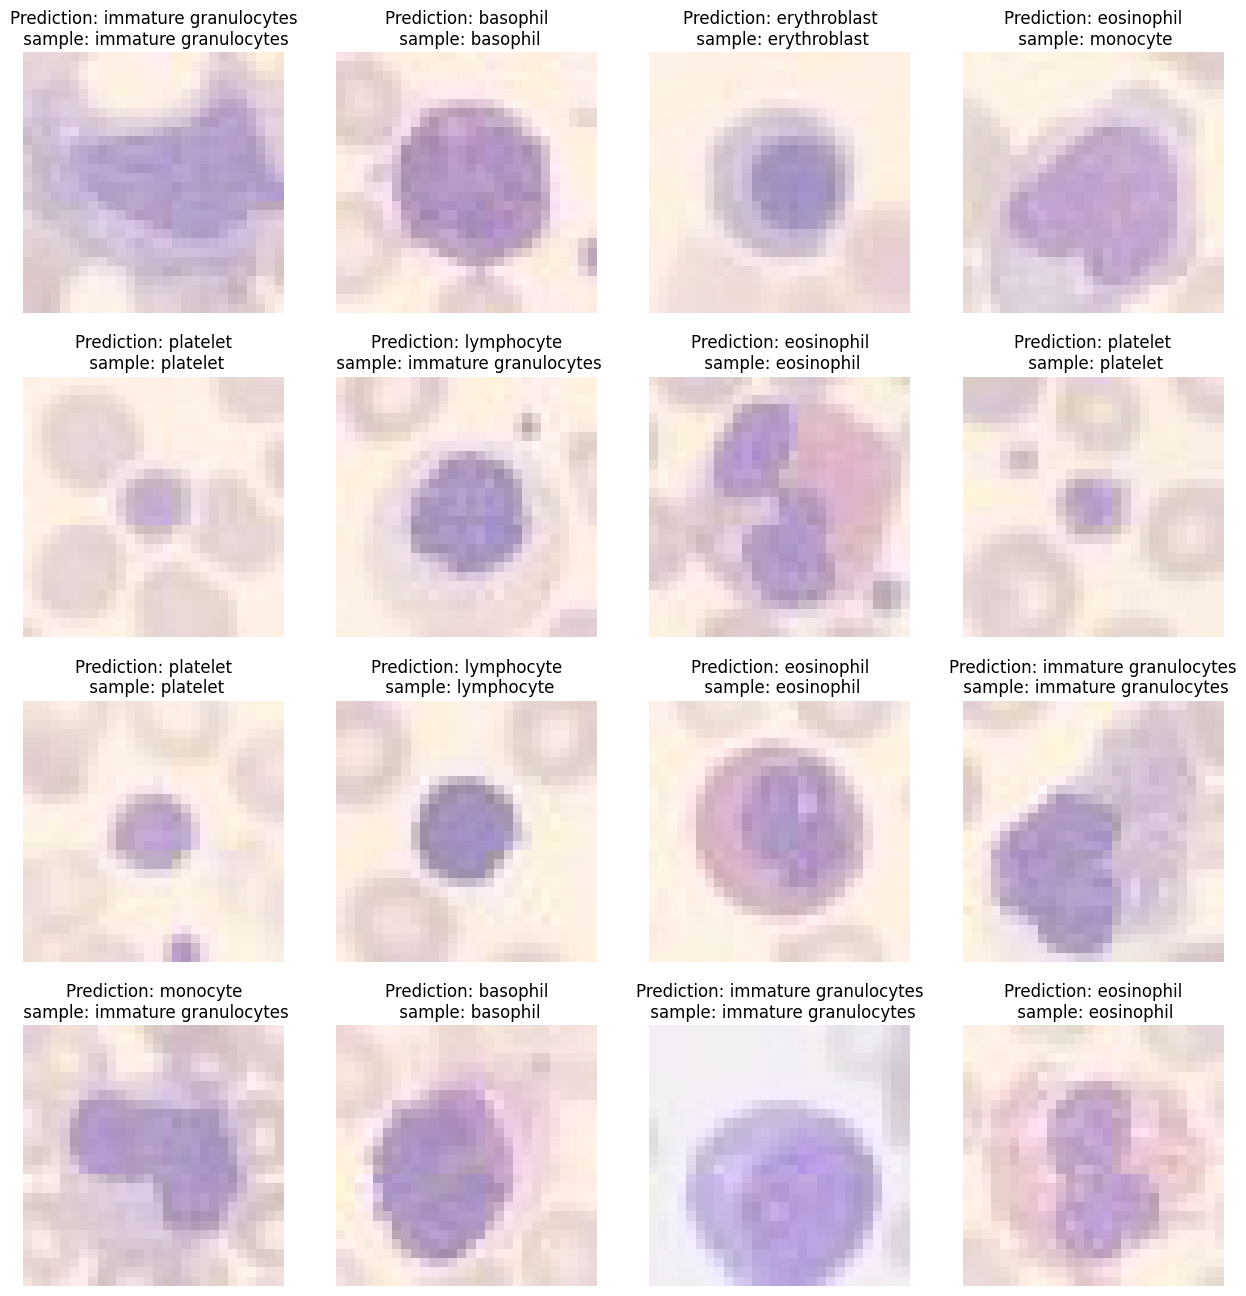

In [33]:
print("CNN Model")
test(cnn_model, test_loader, classes, batch_size, n_classes)